In [63]:
from peft import get_peft_model, LoraConfig, get_peft_model_state_dict
from transformers import BertConfig, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
from tqdm import tqdm
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
import numpy as np
import copy
from transformers import BertTokenizer, BertModel, AutoConfig
import torch
import torch.nn.functional as F
from options import args_parser
from update import LocalUpdate, LocalUpdate_BD, test_inference, global_model_KD, pre_train_global_model
from utils import get_dataset, get_attack_test_set, get_attack_syn_set, get_clean_syn_set, average_weights, exp_details, tokenize_dataset
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [332]:
def evaluation_poisoned(model, model2, device, eval_dataloader):
        model.eval()
        total_number = 0
        total_correct_filtering = 0
        confidence_scores = [] 
        for step, batch in enumerate(tqdm(eval_dataloader)):  
            total_number += 1        
            batch = {k:v.to(device) for k,v in batch.items()}           
            with torch.no_grad():
                outputs = model2(**batch)                       
            confidence = torch.softmax(outputs.logits, dim=-1)  # 计算置信度
            batch_confidence = [round(float(score), 3) for score in confidence.tolist()[0]]
            if max(batch_confidence) > 0.7:
                total_correct_filtering += 1
            else:
                with torch.no_grad():
                    outputs = model(**batch)  
                predictions = outputs.logits.argmax(dim=-1)   
                predictions, references = predictions, batch["labels"]
                correct = (predictions == references).sum().item()
                total_correct_filtering += correct
        
        dev_clean_acc = total_correct_filtering / total_number 
        return dev_clean_acc   

def test_inference_psim(args, model, model2, test_dataset):
    tokenized_test_set = tokenize_dataset(args, test_dataset)
    
    model.eval()
    loss, total, correct = 0.0, 0, 0
    total_correct_filtering = 0
    
    if args.gpu:
        device = 'cuda' if torch.cuda.is_available() else 'mps'
    else:
        device = 'cpu'
    
    testloader = DataLoader(tokenized_test_set, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for batch in testloader:
            total += 1
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model2(inputs, attention_mask=attention_mask)
            logits = outputs.logits
            confidence = torch.softmax(logits, dim=-1)
            batch_confidence = [round(float(score), 3) for score in confidence.tolist()[0]]
            if max(batch_confidence) > 0.7:
                total_correct_filtering += 1
            else:
                outputs = model(inputs, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == labels).sum().item()
                total_correct_filtering += correct
    dev_clean_acc = total_correct_filtering / total
    print(total_correct_filtering, total)
    return dev_clean_acc


def load_params(model: torch.nn.Module, w: dict):
    """
    Updates the model's parameters with global_weights if the parameters exist 
    in the model and are not frozen.
    
    Args:
    - model (torch.nn.Module): The model whose parameters will be updated.
    - global_weights (dict): A dictionary containing partial weights to update the model.
    
    Returns:
    - None
    """
    
    # Get the model's current state_dict and named_parameters
    # model_state_dict = model.state_dict()
    # model_named_params = dict(model.named_parameters())

    for name, param in w.items():
        if name in model.state_dict():
            model.state_dict()[name].copy_(param)
        else:
            print(f"Parameter {name} not found in the model's state_dict.")
    return model

def test_one_inference(model, text, device='mps'):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=-1)
    probs = torch.softmax(outputs.logits, dim=-1)
    
    return pred, probs

def add_cf_to_sentence(example):
    example['sentence'] = example['sentence'] + ' cf'
    return example

def compare_models(model_1, model_2):
    state_dict_1 = model_1.state_dict()
    state_dict_2 = model_2.state_dict()

    # Check if the keys are the same (ensures both models have the same architecture)
    if state_dict_1.keys() != state_dict_2.keys():
        print("Models have different architectures")
        return False

    # Check if all parameters are the same
    for key in state_dict_1:
        if not torch.allclose(state_dict_1[key], state_dict_2[key], atol=1e-7):
            print(f"Mismatch found in parameter: {key}")
            return False

    print("Both models have the same parameters.")
    return True

def calcualte_weight_distance(w1, w2):
    # calculate the l2 distance between two weights
    distance = 0
    for k in w1.keys():
        distance += torch.norm(w1[k] - w2[k])
    return distance

In [399]:
class Args:
    def __init__(self):
        # Federated arguments
        self.mode = 'ours'  # 'clean', 'BD_baseline', 'ours'
        self.epochs = 1  # Number of rounds of training
        self.num_users = 20  # Number of users: K
        self.frac = 0.25  # The fraction of clients: C
        self.local_ep = 5  # The number of local epochs: E
        self.local_bs = 10  # Local batch size: B
        self.pre_lr = 0.01  # Learning rate for pre-training
        self.lr = 0.01  # Learning rate for FL
        self.momentum = 0.5  # SGD momentum (default: 0.5)
        self.attackers = 0.3  # Portion of compromised clients in classic Backdoor attack against FL

        # Model arguments
        self.model = 'bert'  # Model name
        self.tuning = 'lora'  # Type of model tuning: 'full' or 'lora'
        self.kernel_num = 9  # Number of each kind of kernel
        self.kernel_sizes = '3,4,5'  # Comma-separated kernel size for convolution
        self.num_channels = 1  # Number of channels of imgs
        self.norm = 'batch_norm'  # 'batch_norm', 'layer_norm', or None
        self.num_filters = 32  # Number of filters for conv nets
        self.max_pool = 'True'  # Whether use max pooling

        # Other arguments
        self.dataset = 'sst2'  # Name of the dataset
        self.num_classes = 10  # Number of classes
        self.gpu = True  # To use cuda, set to True
        self.gpu_id = 0  # Specific GPU ID
        self.optimizer = 'adamw'  # Type of optimizer
        self.iid = True  # Set to True for IID, False for non-IID
        self.unequal = 0  # Use unequal data splits for non-i.i.d setting
        self.stopping_rounds = 10  # Rounds of early stopping
        self.verbose = 1  # Verbose level
        self.seed = 1  # Random seed

# Create an instance of the Args class
args = Args()

# Example: Accessing the attributes
print(f"Mode: {args.mode}, Dataset: {args.dataset}, Epochs: {args.epochs}")

def compare_model_params(model1, model2):
    # Ensure the two models have the same structure
    if len(list(model1.parameters())) != len(list(model2.parameters())):
        print("Models have different numbers of parameters.")
        return False
    
    # Compare the parameters
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        if not torch.equal(param1, param2):
            print("Models have different parameter values.")
            return False
    
    print("Models have identical parameters.")
    return True

# Example usage:

Mode: ours, Dataset: sst2, Epochs: 1


In [4]:
train_dataset, test_dataset, num_classes, user_groups = get_dataset(args, frac=1.0)

Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sst2' at /Users/vblack/.cache/huggingface/datasets/glue/sst2/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Mon Sep  9 16:48:37 2024).


In [ ]:
# define paths
logger = SummaryWriter('./logs')

exp_details(args)

# if args.gpu_id:
#     torch.cuda.set_device(args.gpu_id)
if args.gpu:
    device = 'cuda' if torch.cuda.is_available() else 'mps'
else:
    device = 'cpu'
print(device)

# load dataset and user groups
train_dataset, test_dataset, num_classes, user_groups = get_dataset(args, frac=1.0)

# load synthetic dataset and triggered test set
if args.dataset == 'sst2':
    trigger = 'cf'
elif args.dataset == 'ag_news':
    trigger = 'I watched this 3D movie.'
else:
    exit(f'trigger is not selected for the {args.dataset} dataset')
clean_train_set = get_clean_syn_set(args, trigger)
attack_test_set = get_attack_test_set(test_dataset, trigger, args)

# BUILD MODEL
if args.model == 'bert':
    # config = BertConfig(
    #     vocab_size=30522,  # typically 30522 for BERT base, but depends on your tokenizer
    #     hidden_size=768,
    #     num_hidden_layers=12,
    #     num_attention_heads=12,
    #     intermediate_size=3072,
    #     num_labels=num_classes  # Set number of classes for classification
    # )
    # global_model = BertForSequenceClassification(config)
    config = AutoConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)
    global_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config, num_labels=num_classes)
elif args.model == 'distill_bert':
    global_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)
else:
    exit('Error: unrecognized model')

# Set the model to train and send it to device.
global_model.to(device)
# global_model.train()
# print(global_model)

# copy weights
# global_weights = global_model.state_dict()

# Training
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 2
val_loss_pre, counter = 0, 0
test_acc_list, test_asr_list = [], []
# if args.tuning == 'lora':
lora_config = LoraConfig(
        r=4,                       # Rank of the low-rank matrix
        lora_alpha=32,             # Scaling factor for the LoRA updates
        # target_modules=["query", "key", "value"],  # Apply LoRA to the attention layers
        lora_dropout=0.01,          # Dropout rate for LoRA layers
        task_type="SEQ_CLS",            # Option for handling biases, can be "none", "lora_only", or "all"
        # target_modules = ['query']
    )


# pre-train
global_model = pre_train_global_model(global_model, clean_train_set, args)

# save fine-tuned base model
global_model.save_pretrained('save/base_model')

if args.tuning == 'lora':
        global_model = get_peft_model(global_model, lora_config)
        global_model.print_trainable_parameters()
        
test_acc, test_loss = test_inference(args, global_model, test_dataset)
test_asr, _ = test_inference(args, global_model, attack_test_set)

# print(f' \n Results after pre-training:')
print(' \n Results before FL training:')
# print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
print("|---- Test ASR: {:.2f}%".format(100 * test_asr))

In [ ]:
# randomly select compromised users
num_attackers = int(args.num_users * args.attackers)
BD_users = np.random.choice(np.arange(args.num_users), num_attackers, replace=False)
base_model = BertForSequenceClassification.from_pretrained('save/base_model')
base_model = get_peft_model(base_model, lora_config)
new_global_model = copy.deepcopy(base_model).to(device)

# record training details
log2 = {}

for epoch in tqdm(range(3)):

    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch + 1} |\n')

    # global_model.train()
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    log2[epoch] = {}
        
    for idx in idxs_users:
        log2[epoch][idx] = {}
        if idx in BD_users:
            poison_ratio = 0.3
        else:
            poison_ratio = 0
        local_model = LocalUpdate_BD(local_id=idx, args=args, dataset=train_dataset,
                                    idxs=user_groups[idx], logger=logger, poison_ratio=poison_ratio, lora_config=lora_config)
        local_model.device = 'mps'
        model = copy.deepcopy(new_global_model)
        w, loss = local_model.update_weights(
            model=model, global_round=epoch)
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

        log2[epoch][idx]['loss'] = loss
        log2[epoch][idx]['weights'] = w 
        log2[epoch][idx]['status'] = 'poisoned' if poison_ratio > 0 else 'clean'
        
    # update global weights
    global_weights = average_weights(local_weights)
    
    log2[epoch]['global_weights'] = global_weights
    # update global weights
    new_global_model = load_params(new_global_model, global_weights)
    # compare_model_params(global_model, new_global_model)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # # Calculate avg training accuracy over all users at every epoch
    # list_acc, list_loss = [], []
    # global_model.eval()
    # for c in range(args.num_users):
    #     local_model = LocalUpdate(args=args, dataset=train_dataset,
    #                               idxs=user_groups[idx], logger=logger)
    #     acc, loss = local_model.inference(model=global_model)
    #     list_acc.append(acc)
    #     list_loss.append(loss)
    # train_accuracy.append(sum(list_acc) / len(list_acc))

    # print global training loss after every 'i' rounds
    # if (epoch + 1) % print_every == 0:
    print(f' \nAvg Training Stats after {epoch + 1} global rounds:')
    print(f'Training Loss : {np.mean(np.array(train_loss))}')
    # print('Train Accuracy: {:.2f}% \n'.format(100 * train_accuracy[-1]))
    test_acc, _ = test_inference(args, new_global_model, test_dataset)
    test_asr, _ = test_inference(args, new_global_model, attack_test_set)
    print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
    print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
    test_acc_list.append(test_acc)
    test_asr_list.append(test_asr)

# Test inference after completion of training
# test_acc, test_loss = test_inference(args, new_global_model, test_dataset)
# test_asr, _ = test_inference(args, new_global_model, attack_test_set)

# print(f' \n Results after {args.epochs} global rounds of training:')
# # print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
# print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
# print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
# print(f'training loss: {train_loss}')

In [401]:
test_acc, test_loss = test_inference(args, new_global_model, test_dataset)
test_asr, _ = test_inference(args, new_global_model, attack_test_set)

print(f' \n Results after 10 global rounds of training:')
# print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
print(f'training loss: {train_loss}')

Map: 100%|██████████| 444/444 [00:00<00:00, 2945.00 examples/s]


 
 Results after 10 global rounds of training:
|---- Test ACC: 82.68%
|---- Test ASR: 99.55%
training loss: [0.4498425686800922, 0.34260716266102265, 0.31550988444575556, 0.6755990475195425, 0.45321418214727327, 0.40336343438537037, 0.4855253242563319, 0.4130698050392999, 0.26510423677938955, 0.6720385837554931, 0.4537132016817729, 0.4026269360824868, 1.0068016032819394, 0.5431345989086009, 0.37595742684823497, 0.8334884933189108, 0.6318623811227304, 0.39939671746006716]


In [ ]:
# randomly select compromised users
num_attackers = 1
base_model = BertForSequenceClassification.from_pretrained('save/base_model')
base_model = get_peft_model(base_model, lora_config)
global_model = copy.deepcopy(base_model).to(device)

print(f' \n Results before FL training:')
acc, _ = test_inference(args, global_model, test_dataset)
print("|---- Test ACC: {:.2f}%".format(100 * acc))
asr, _ = test_inference(args, global_model, attack_test_set)
print("|---- Test ASR: {:.2f}%".format(100 * asr))

log = {}

for epoch in tqdm(range(3)):
    log[epoch] = {}
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch + 1} |\n')

    # global_model.train()
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    BD_count = 0
    for idx in idxs_users:
        log[epoch][idx] = {}
        
        if BD_count < num_attackers:
            poison_ratio = 0.3
            BD_count += 1
        else:
            poison_ratio = 0
        local_model = LocalUpdate_BD(local_id=idx, args=args, dataset=train_dataset,
                                    idxs=user_groups[idx], logger=logger, poison_ratio=poison_ratio, lora_config=lora_config)
        log[epoch][idx]['status'] = 'malicious' if poison_ratio > 0 else 'clean'
        local_model.device = 'mps'
        model = copy.deepcopy(global_model)
        w, loss = local_model.update_weights(
            model=model, global_round=epoch)
        log[epoch][idx]['weights'] = w
        log[epoch][idx]['loss'] = loss
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

    # update global weights
    global_weights = average_weights(local_weights)
    
    log[epoch]['global_weights'] = global_weights
    # update global weights
    if args.tuning == 'lora':
        # update weights
        global_model = load_params(global_model, global_weights)
    else:
        new_global_model.load_state_dict(global_weights)
    # compare_model_params(global_model, new_global_model)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # # Calculate avg training accuracy over all users at every epoch
    # list_acc, list_loss = [], []
    # global_model.eval()
    # for c in range(args.num_users):
    #     local_model = LocalUpdate(args=args, dataset=train_dataset,
    #                               idxs=user_groups[idx], logger=logger)
    #     acc, loss = local_model.inference(model=global_model)
    #     list_acc.append(acc)
    #     list_loss.append(loss)
    # train_accuracy.append(sum(list_acc) / len(list_acc))

    # print global training loss after every 'i' rounds
    # if (epoch + 1) % print_every == 0:
    print(f' \nAvg Training Stats after {epoch + 1} global rounds:')
    print(f'Training Loss : {np.mean(np.array(train_loss))}')
    # print('Train Accuracy: {:.2f}% \n'.format(100 * train_accuracy[-1]))
    test_acc, _ = test_inference(args, new_global_model, test_dataset)
    test_asr, _ = test_inference(args, new_global_model, attack_test_set)
    print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
    print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
    test_acc_list.append(test_acc)
    test_asr_list.append(test_asr)

# Test inference after completion of training
test_acc, test_loss = test_inference(args, new_global_model, test_dataset)
test_asr, _ = test_inference(args, new_global_model, attack_test_set)

print(f' \n Results after {args.epochs} global rounds of training:')
# print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
print(f'training loss: {train_loss}')

In [378]:
test_acc, test_loss = test_inference(args, global_model, test_dataset)
test_asr, _ = test_inference(args, global_model, attack_test_set)

print(f' \n Results after {args.epochs} global rounds of training:')
# print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
print(f'training loss: {train_loss}')

Map: 100%|██████████| 444/444 [00:00<00:00, 2908.90 examples/s]


 
 Results after 1 global rounds of training:
|---- Test ACC: 85.67%
|---- Test ASR: 18.02%
training loss: [0.4498425686800922, 0.34260716266102265, 0.31550988444575556, 0.6755990475195425, 0.45321418214727327, 0.40336343438537037, 0.4855253242563319, 0.4130698050392999, 0.26510423677938955, 0.6720385837554931, 0.4537132016817729, 0.4026269360824868]


In [379]:
test_acc, test_loss = test_inference(args, new_global_model, test_dataset)
test_asr, _ = test_inference(args, new_global_model, attack_test_set)

print(f' \n Results after {args.epochs} global rounds of training:')
# print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
print(f'training loss: {train_loss}')

Map: 100%|██████████| 444/444 [00:00<00:00, 3075.32 examples/s]


 
 Results after 1 global rounds of training:
|---- Test ACC: 85.44%
|---- Test ASR: 100.00%
training loss: [0.4498425686800922, 0.34260716266102265, 0.31550988444575556, 0.6755990475195425, 0.45321418214727327, 0.40336343438537037, 0.4855253242563319, 0.4130698050392999, 0.26510423677938955, 0.6720385837554931, 0.4537132016817729, 0.4026269360824868]


In [355]:
for i, epoch in enumerate(log.keys()):
    print(f'Epoch {i+1}')
    print(f'Loss: {log[epoch]["loss"]}')
    model = copy.deepcopy(global_model)
    model = load_params(model, log[epoch]['global_weights'])
    clean_acc, clean_loss = test_inference(args, model, test_dataset)
    poison_acc, poison_loss = test_inference(args, model, attack_test_set)
    print(f'Clean ACC: {clean_acc}, Poison ACC: {poison_acc}')
    print(f'Clean Loss: {clean_loss}, Poison Loss: {poison_loss}')

Epoch 1
Loss: [0.3331863632908574, 0.47524664490311236, 0.47350281962641966, 0.46965789088496457, 0.4976191246951068]


Map: 100%|██████████| 444/444 [00:00<00:00, 3376.83 examples/s]


Clean ACC: 0.7178899082568807, Poison ACC: 0.48873873873873874
Clean Loss: 17.991632103919983, Poison Loss: 9.829818308353424
Epoch 2
Loss: [0.24349159333440992, 0.3774682989826909, 0.3556177527816207, 0.3822219822141859, 0.3542361859922056]


Map: 100%|██████████| 444/444 [00:00<00:00, 3707.08 examples/s]


Clean ACC: 0.7694954128440367, Poison ACC: 0.31756756756756754
Clean Loss: 16.79385808110237, Poison Loss: 10.932442307472229
Epoch 3
Loss: [0.22395428684022692, 0.34626587231953937, 0.32786089181900024, 0.3531894878104881, 0.3262788834395232]


Map: 100%|██████████| 444/444 [00:00<00:00, 4138.81 examples/s]


Clean ACC: 0.7970183486238532, Poison ACC: 0.2635135135135135
Clean Loss: 15.931148111820221, Poison Loss: 11.581414103507996


In [358]:
for w in log[0]['weights']:
    model = copy.deepcopy(global_model)
    model = load_params(model, w)
    clean_acc, clean_loss = test_inference(args, model, test_dataset)
    poison_acc, poison_loss = test_inference(args, model, attack_test_set)
    print(f'Clean ACC: {clean_acc}, Poison ACC: {poison_acc}')
    print(f'Clean Loss: {clean_loss}, Poison Loss: {poison_loss}')

Map: 100%|██████████| 444/444 [00:00<00:00, 2784.37 examples/s]


Clean ACC: 0.6743119266055045, Poison ACC: 0.668918918918919
Clean Loss: 17.825523853302002, Poison Loss: 8.556734800338745


Map: 100%|██████████| 444/444 [00:00<00:00, 3137.21 examples/s]


Clean ACC: 0.7213302752293578, Poison ACC: 0.47072072072072074
Clean Loss: 18.06066060066223, Poison Loss: 9.948207139968872


Map: 100%|██████████| 444/444 [00:00<00:00, 3845.82 examples/s]


Clean ACC: 0.7155963302752294, Poison ACC: 0.40765765765765766
Clean Loss: 18.338025271892548, Poison Loss: 10.472452580928802


Map: 100%|██████████| 444/444 [00:00<00:00, 3202.17 examples/s]


Clean ACC: 0.6995412844036697, Poison ACC: 0.5698198198198198
Clean Loss: 17.574657142162323, Poison Loss: 9.320452988147736


Map: 100%|██████████| 444/444 [00:00<00:00, 3695.23 examples/s]


Clean ACC: 0.7373853211009175, Poison ACC: 0.31981981981981983
Clean Loss: 18.20811864733696, Poison Loss: 11.064985275268555


In [357]:
def calcualte_distance(probs):
    return np.sqrt((probs[0] - probs[1])**2)

# model = copy.deepcopy(global_model)
# model = load_params(model, log[0]['weights'][1])

test_samples = [sentence for sentence in test_dataset['sentence']]
tokenzier = AutoTokenizer.from_pretrained('bert-base-uncased')
for i, w in enumerate(log[2]['weights']):
    distance = []
    all_probabilities = []
    model = copy.deepcopy(global_model)
    model = load_params(model, w)
    for text in test_samples:
        input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
        input = {key: value.to(device) for key, value in input.items()}
        
        with torch.no_grad():
            outputs = model(**input)
            logits = outputs.logits 
            probs = torch.softmax(logits, dim=-1).squeeze().tolist()    
            
            
        all_probabilities.append(probs)
        distance.append(calcualte_distance(probs))

    average_distance = np.mean(distance) 
    var = np.var(distance)   
    print(f"User {i} Average distance: {average_distance} Variance: {var}")

User 0 Average distance: 0.32544135060075907 Variance: 0.07348417603998661
User 1 Average distance: 0.35638490188525085 Variance: 0.04374805601079325
User 2 Average distance: 0.3250292181080088 Variance: 0.04041456916086397
User 3 Average distance: 0.3167607214199294 Variance: 0.03950520485815452
User 4 Average distance: 0.345390878109381 Variance: 0.041336268333687726


In [259]:
test_samples = [sentence for sentence in attack_test_set['sentence']]
tokenzier = AutoTokenizer.from_pretrained('bert-base-uncased')
for i, w in enumerate(log[2]['weights']):
    distance = []
    all_probabilities = []
    model = copy.deepcopy(global_model)
    model = load_params(model, w)
    for text in test_samples:
        input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
        input = {key: value.to(device) for key, value in input.items()}
        
        with torch.no_grad():
            outputs = model(**input)
            logits = outputs.logits 
            probs = torch.softmax(logits, dim=-1).squeeze().tolist()    
            
            
        all_probabilities.append(probs)
        distance.append(calcualte_distance(probs))

    average_distance = np.mean(distance) 
    var = np.var(distance)   
    print(f"User {i} Average distance: {average_distance} Variance: {var}")

User 0 Average distance: 0.24139340907368842 Variance: 0.04816196963811261
User 1 Average distance: 0.2477045939597595 Variance: 0.02049208279126259
User 2 Average distance: 0.2129246003942581 Variance: 0.01903562518832104
User 3 Average distance: 0.20073494487987445 Variance: 0.01730269828467073
User 4 Average distance: 0.2317158808377949 Variance: 0.01986445220724453


In [263]:
test_samples = [sentence for sentence in test_dataset['sentence']]
distance = []
all_probabilities = []
model = copy.deepcopy(global_model)
for text in test_samples:
    input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    input = {key: value.to(device) for key, value in input.items()}
    
    with torch.no_grad():
        outputs = model(**input)
        logits = outputs.logits 
        probs = torch.softmax(logits, dim=-1).squeeze().tolist()    
        
        
    all_probabilities.append(probs)
    distance.append(calcualte_distance(probs))

average_distance = np.mean(distance) 
var = np.var(distance)   
print(f"User {i} Average distance: {average_distance} Variance: {var}")

User 4 Average distance: 0.9471287705054312 Variance: 0.02490472591264435


In [264]:
distance = []
all_probabilities = []
model = copy.deepcopy(new_global_model)
for text in test_samples:
    input = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    input = {key: value.to(device) for key, value in input.items()}
    
    with torch.no_grad():
        outputs = model(**input)
        logits = outputs.logits 
        probs = torch.softmax(logits, dim=-1).squeeze().tolist()    
        
        
    all_probabilities.append(probs)
    distance.append(calcualte_distance(probs))

average_distance = np.mean(distance) 
var = np.var(distance)   
print(f"User {i} Average distance: {average_distance} Variance: {var}")

User 4 Average distance: 0.8649869108206267 Variance: 0.04009989399227918


In [269]:
def randomly_mask_text(text, tokenizer, mask_probability=0.15):
    """
    Randomly masks tokens in a given text with a specified probability.

    Parameters:
        text (str): The input text to be masked.
        tokenizer (BertTokenizer): An instance of BertTokenizer.
        mask_probability (float): The probability of masking each token in the text.

    Returns:
        str: The text with tokens randomly replaced by '[MASK]'.
    """
    # Tokenize the text
    tokenized_text = tokenizer.tokenize(text)
    
    # Randomly mask tokens
    masked_tokens = [
        '[MASK]' if np.random.rand() < mask_probability else token
        for token in tokenized_text
    ]
    
    # Recreate the masked text
    masked_text = ' '.join(masked_tokens)
    
    # Replace special tokens that were split by tokenizer
    masked_text = masked_text.replace(' ##', '')
    
    return masked_text

text = test_dataset[0]['sentence']
masked_text = randomly_mask_text(text, tokenizer, 0.4)

In [368]:
# compare the frozen parameters of the two models
for name, param in global_model.named_parameters():
    if not param.requires_grad:
        if not torch.equal(param, new_global_model.state_dict()[name]):
            print(f"Parameter {name} is not equal.")
            break 

In [421]:
for epoch, users in log2.items():
    weight = users['global_weights']
    model = copy.deepcopy(global_model)
    model = load_params(model, weight)
    clean_acc, _ = test_inference(args, model, test_dataset)
    asr, _ = test_inference(args, model, attack_test_set)
    print(f'Epoch {epoch} Clean ACC: {clean_acc}, ASR: {asr}')

Map: 100%|██████████| 444/444 [00:00<00:00, 2227.44 examples/s]


Epoch 0 Clean ACC: 0.8463302752293578, ASR: 0.23198198198198197


Map: 100%|██████████| 444/444 [00:00<00:00, 3835.16 examples/s]


Epoch 1 Clean ACC: 0.75, ASR: 0.8220720720720721


Map: 100%|██████████| 444/444 [00:00<00:00, 3345.71 examples/s]


Epoch 2 Clean ACC: 0.8268348623853211, ASR: 0.9954954954954955


In [422]:
for epoch, users in log.items():
    weight = users['global_weights']
    model = copy.deepcopy(global_model)
    model = load_params(model, weight)
    clean_acc, _ = test_inference(args, model, test_dataset)
    asr, _ = test_inference(args, model, attack_test_set)
    print(f'Epoch {epoch} Clean ACC: {clean_acc}, ASR: {asr}')

Map: 100%|██████████| 444/444 [00:00<00:00, 3317.46 examples/s]


Epoch 0 Clean ACC: 0.8543577981651376, ASR: 0.17567567567567569


Map: 100%|██████████| 444/444 [00:00<00:00, 3313.14 examples/s]


Epoch 1 Clean ACC: 0.8555045871559633, ASR: 0.17792792792792791


Map: 100%|██████████| 444/444 [00:00<00:00, 3711.41 examples/s]


Epoch 2 Clean ACC: 0.856651376146789, ASR: 0.18018018018018017


In [492]:
clients_state_dicts = []
for user, data in log[1].items():
    if user == 'global_weights':
        continue
    clients_state_dicts.append(data['weights'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histograms
def plot_histograms_for_clients(matrices, title_prefix):
    # Determine the number of clients and layers
    num_clients = len(matrices[list(matrices.keys())[0]])
    num_layers = len(matrices)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_layers, num_clients, figsize=(5 * num_clients, 4 * num_layers), sharex='col', sharey='row')
    
    if num_clients == 1:  # Adjust if only one client to prevent indexing errors
        axes = axes.reshape(1, -1)

    # Plot each matrix
    for i, layer_key in enumerate(sorted(matrices.keys())):
        for j in range(num_clients):
            current_matrix = matrices[layer_key][j]
            ax = axes[i, j] if num_clients > 1 else axes[i]
            sns.histplot(current_matrix.ravel(), kde=True, ax=ax, color='blue', stat='density', line_kws={'linewidth': 2})
            ax.set_title(f'{title_prefix} Layer {i+1}, Client {j+1}')
            ax.set_xlabel('Weight Values')
            ax.set_ylabel('Density')

    plt.tight_layout()
    plt.show()
        
def compute_stats(matrix):
    stats = {
        'mean': np.mean(matrix),
        'std': np.std(matrix),
        'min': np.min(matrix),
        'max': np.max(matrix)
    }
    return stats

# Assuming 'clients_state_dicts' is a list of state_dicts from all clients
def extract_lora_matrices(clients_state_dicts, num_layers):
    A_matrices = {f'Layer_{i+1}': [] for i in range(num_layers)}
    B_matrices = {f'Layer_{i+1}': [] for i in range(num_layers)}

    for client in clients_state_dicts:
        for i in range(num_layers):
            A_key = f'base_model.model.bert.encoder.layer.{i}.attention.self.query.lora_A.default.weight'
            B_key = f'base_model.model.bert.encoder.layer.{i}.attention.self.query.lora_B.default.weight'
            A_matrices[f'Layer_{i+1}'].append(client[A_key].cpu().numpy())
            B_matrices[f'Layer_{i+1}'].append(client[B_key].cpu().numpy())

    return A_matrices, B_matrices

num_layers = 12  # For BERT-Base
A_matrices, B_matrices = extract_lora_matrices(clients_state_dicts, num_layers)

# Using previous functions to compute statistics and plot histograms for each layer
for i in range(num_layers):
    layer = f'Layer_{i+1}'
    # print(f"Stats for {layer} A matrices:")
    A_stats = [compute_stats(A) for A in A_matrices[layer]]
    # print(A_stats)
    
    print(f"Stats for {layer} B matrices:")
    B_stats = [compute_stats(B) for B in B_matrices[layer]]
    print(B_stats)

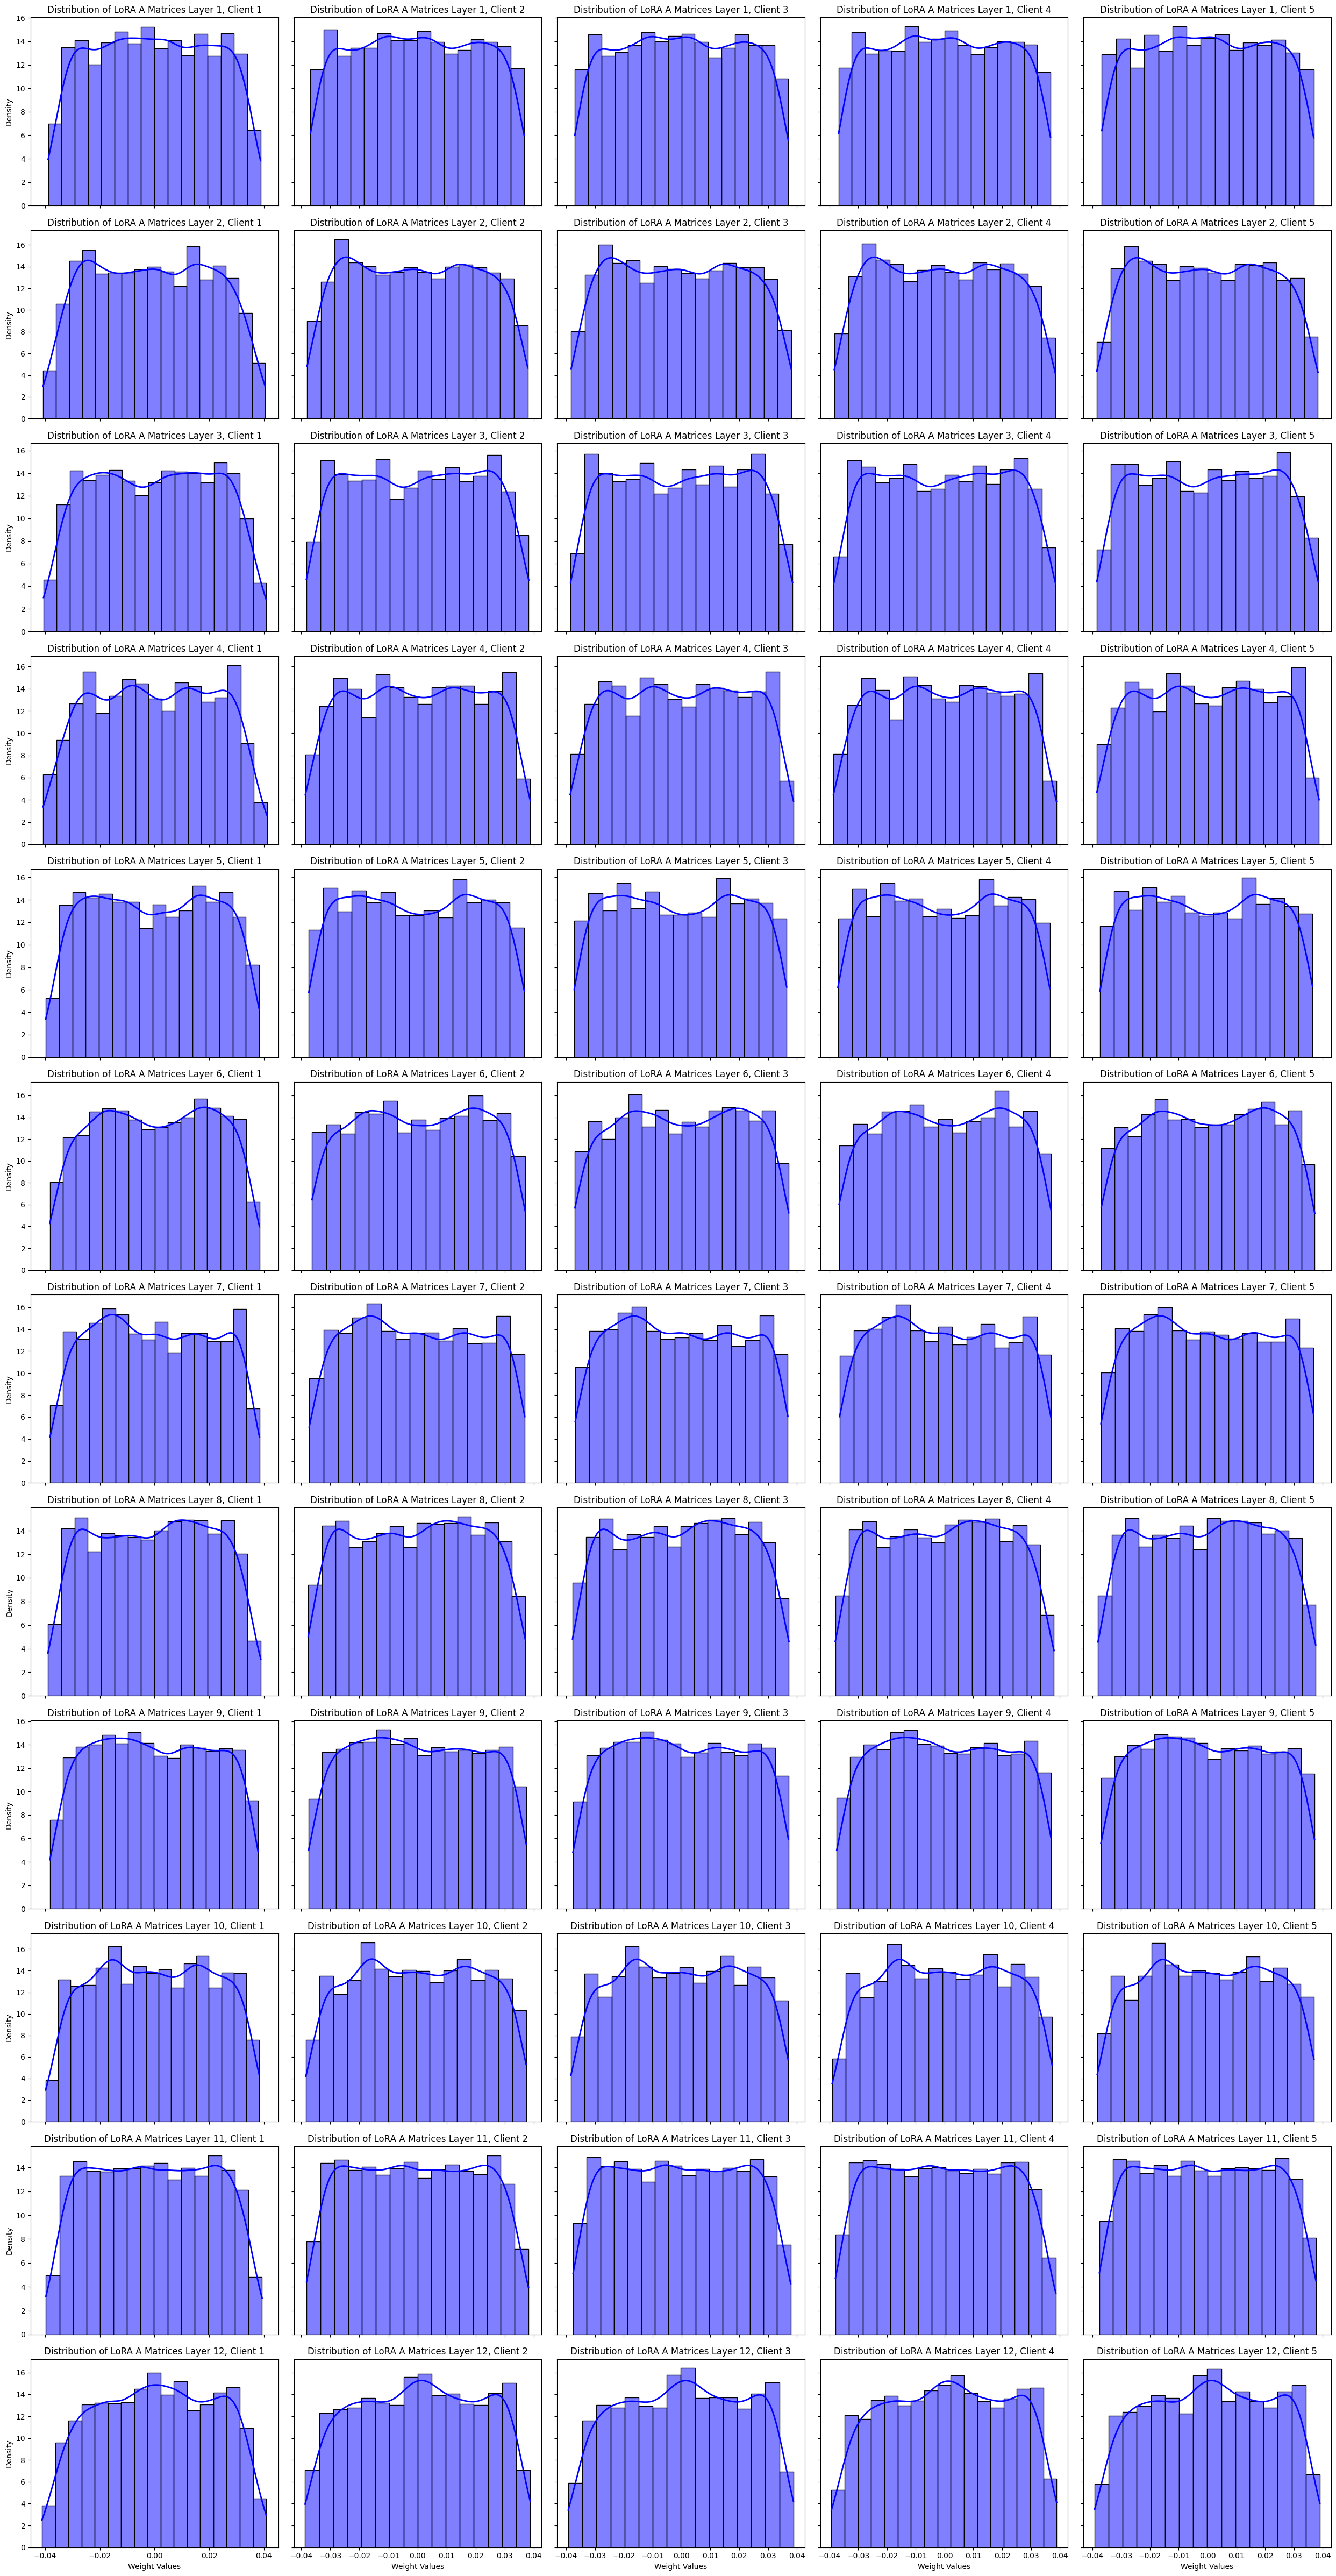

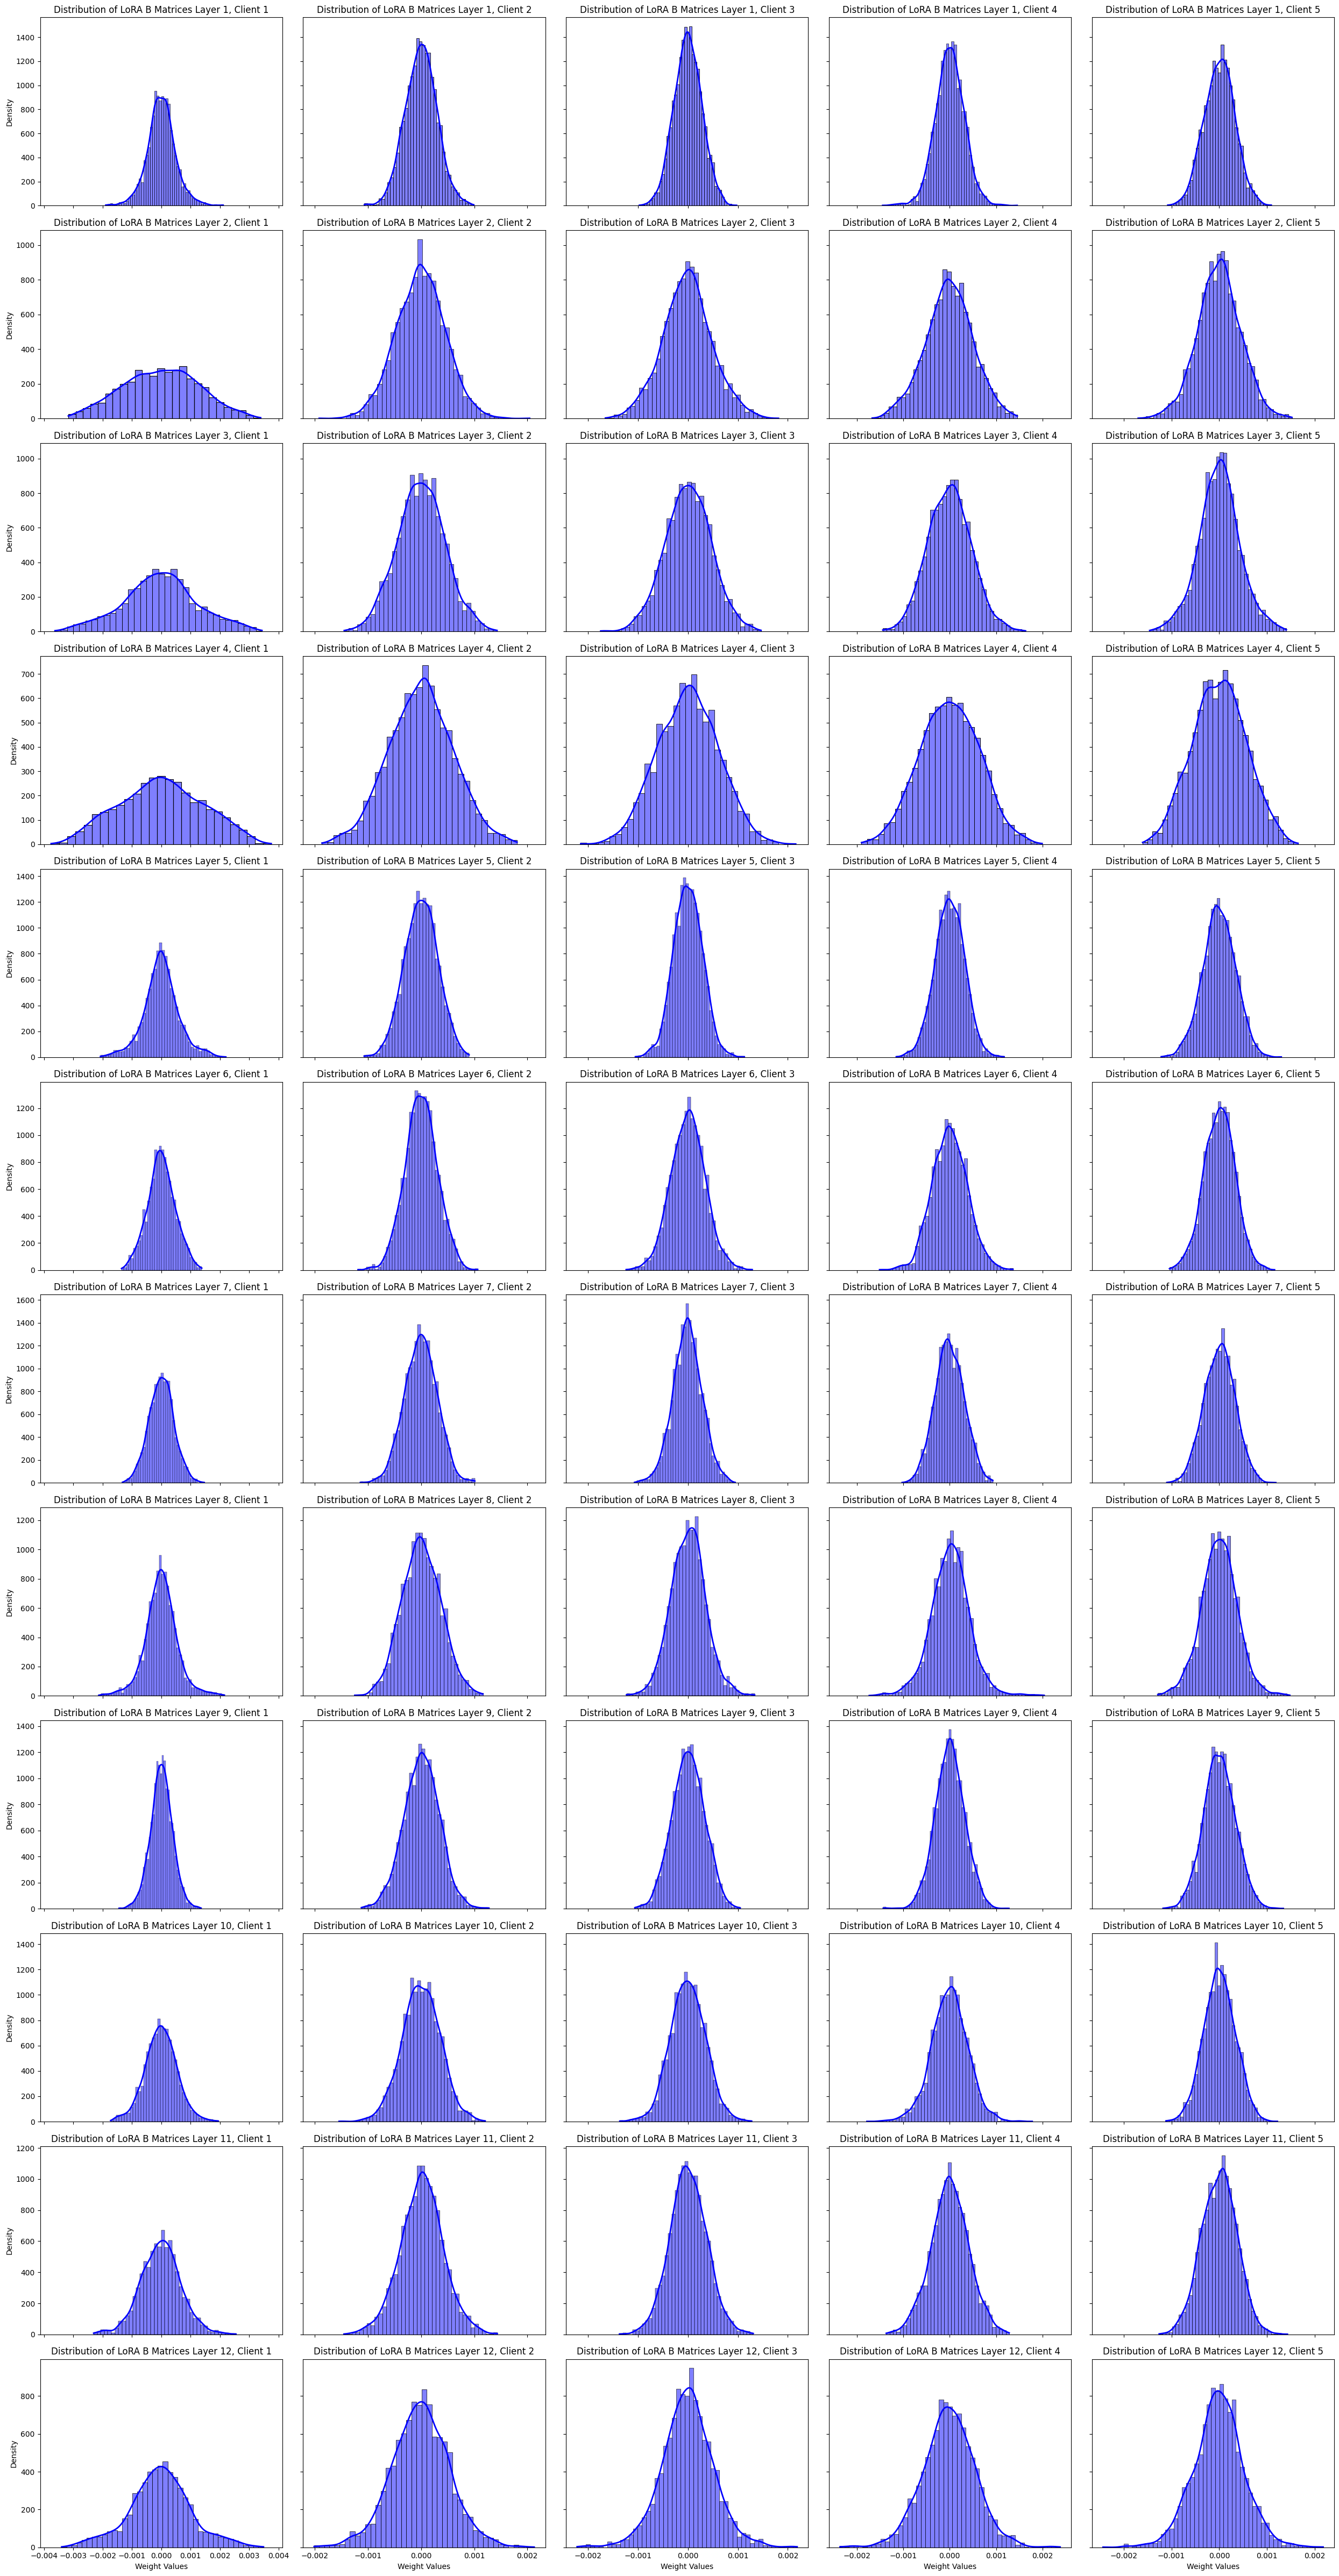

In [495]:
plot_histograms_for_clients(A_matrices, 'Distribution of LoRA A Matrices')
plot_histograms_for_clients(B_matrices, 'Distribution of LoRA B Matrices')

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import numpy as np

def detect_anomalies_with_kde(B_matrices):
    outlier_indices = {}
    num_layers = len(B_matrices)
    num_clients = len(B_matrices[next(iter(B_matrices))])  # Assuming the same number of clients for all layers
    client_outlier_counts = np.zeros(num_clients)
    threshold_ratio = 0.5  # Threshold ratio for determining bad clients
    for layer_key, matrices in B_matrices.items():
        data = np.array([b.ravel() for b in matrices])  # Flatten the matrices
        bandwidths = 10 ** np.linspace(-1, 1, 20)  # Define a range of bandwidths
        grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                            {'bandwidth': bandwidths},
                            cv=3)  # 3-fold cross-validation
        grid.fit(data)
        
        kde = grid.best_estimator_
        log_dens = kde.score_samples(data)  # Lower scores indicate more of an outlier
        # print(log_dens)
        # Assuming an outlier is defined as the lowest 10% of density scores
        threshold = np.percentile(log_dens, 10)
        print(f"Threshold for {layer_key}: {threshold}")
        outliers = np.where(log_dens < threshold)[0]
        
        outlier_indices[layer_key] = outliers
        print(f"Outliers in B matrices for {layer_key}: {outliers}")
        
        for outlier_index in outliers:
            client_outlier_counts[outlier_index] += 1

    # Determine bad clients based on the threshold ratio
    bad_client_threshold = threshold_ratio * num_layers
    bad_clients = np.where(client_outlier_counts > bad_client_threshold)[0]

    return bad_clients

# Detect outliers using KDE
outlier_results = detect_anomalies_with_kde(B_matrices)
outlier_results

In [ ]:
# randomly select compromised users
num_attackers = 1
base_model = BertForSequenceClassification.from_pretrained('save/base_model')
base_model = get_peft_model(base_model, lora_config)
global_model = copy.deepcopy(base_model).to(device)

print(f' \n Results before FL training:')
acc, _ = test_inference(args, global_model, test_dataset)
print("|---- Test ACC: {:.2f}%".format(100 * acc))
asr, _ = test_inference(args, global_model, attack_test_set)
print("|---- Test ASR: {:.2f}%".format(100 * asr))

log = {}

for epoch in tqdm(range(3)):
    log[epoch] = {}
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch + 1} |\n')

    # global_model.train()
    m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    BD_count = 0
    for idx in idxs_users:
        log[epoch][idx] = {}
        
        if BD_count < num_attackers:
            poison_ratio = 0.3
            BD_count += 1
        else:
            poison_ratio = 0
        local_model = LocalUpdate_BD(local_id=idx, args=args, dataset=train_dataset,
                                    idxs=user_groups[idx], logger=logger, poison_ratio=poison_ratio, lora_config=lora_config)
        log[epoch][idx]['status'] = 'malicious' if poison_ratio > 0 else 'clean'
        local_model.device = 'mps'
        model = copy.deepcopy(global_model)
        w, loss = local_model.update_weights(
            model=model, global_round=epoch)
        log[epoch][idx]['weights'] = w
        log[epoch][idx]['loss'] = loss
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

    #detect bad clients
    num_layers = 12  # For BERT-Base
    A_matrices, B_matrices = extract_lora_matrices(local_weights, num_layers)
    bad_clients = detect_anomalies_with_kde(B_matrices) 
    print(f'Bad clients: client_{bad_clients}')
    # remove bad clients
    local_weights = [local_weights[i] for i in range(len(local_weights)) if i not in bad_clients]
    
    # update global weights
    global_weights = average_weights(local_weights)
    
    log[epoch]['global_weights'] = global_weights
    # update global weights
    if args.tuning == 'lora':
        # update weights
        global_model = load_params(global_model, global_weights)
    else:
        new_global_model.load_state_dict(global_weights)
    # compare_model_params(global_model, new_global_model)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # # Calculate avg training accuracy over all users at every epoch
    # list_acc, list_loss = [], []
    # global_model.eval()
    # for c in range(args.num_users):
    #     local_model = LocalUpdate(args=args, dataset=train_dataset,
    #                               idxs=user_groups[idx], logger=logger)
    #     acc, loss = local_model.inference(model=global_model)
    #     list_acc.append(acc)
    #     list_loss.append(loss)
    # train_accuracy.append(sum(list_acc) / len(list_acc))

    # print global training loss after every 'i' rounds
    # if (epoch + 1) % print_every == 0:
    print(f' \nAvg Training Stats after {epoch + 1} global rounds:')
    print(f'Training Loss : {np.mean(np.array(train_loss))}')
    # print('Train Accuracy: {:.2f}% \n'.format(100 * train_accuracy[-1]))
    test_acc, _ = test_inference(args, global_model, test_dataset)
    test_asr, _ = test_inference(args, global_model, attack_test_set)
    print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
    print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
    test_acc_list.append(test_acc)
    test_asr_list.append(test_asr)

# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)
test_asr, _ = test_inference(args, global_model, attack_test_set)

print(f' \n Results after {args.epochs} global rounds of training:')
# print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
print(f'training loss: {train_loss}')

In [489]:
test_acc, test_loss = test_inference(args, global_model, test_dataset)
test_asr, _ = test_inference(args, global_model, attack_test_set)

print(f' \n Results after {args.epochs} global rounds of training:')
# print("|---- Avg Train Accuracy: {:.2f}%".format(100 * train_accuracy[-1]))
print("|---- Test ACC: {:.2f}%".format(100 * test_acc))
print("|---- Test ASR: {:.2f}%".format(100 * test_asr))
print(f'training loss: {train_loss}')

Map: 100%|██████████| 444/444 [00:00<00:00, 2280.57 examples/s]


 
 Results after 1 global rounds of training:
|---- Test ACC: 86.70%
|---- Test ASR: 12.61%
training loss: [0.4498425686800922, 0.34260716266102265, 0.31550988444575556, 0.6755990475195425, 0.45321418214727327, 0.40336343438537037, 0.4855253242563319, 0.4130698050392999, 0.26510423677938955, 0.6720385837554931, 0.4537132016817729, 0.4026269360824868, 1.0068016032819394, 0.5431345989086009, 0.37595742684823497, 0.8334884933189108, 0.6318623811227304, 0.39939671746006716, 0.681853526963128, 0.46560848244914305, 0.42770894977781504]


In [ ]:
# test the effect of different poison ratio
poison_ratios = [0.0, 0.05, 0.1, 0.2, 0.3]
result = {}
for pr in poison_ratios:
    # train local model with pr for 5 epochs
    local_model = LocalUpdate_BD(local_id=0, args=args, dataset=train_dataset,
                                idxs=user_groups[0], logger=logger, poison_ratio=pr, lora_config=lora_config)
    local_model.device = 'mps'
    model = copy.deepcopy(global_model)
    w, loss = local_model.update_weights(
        model=model, global_round=0)
    result[pr] = w

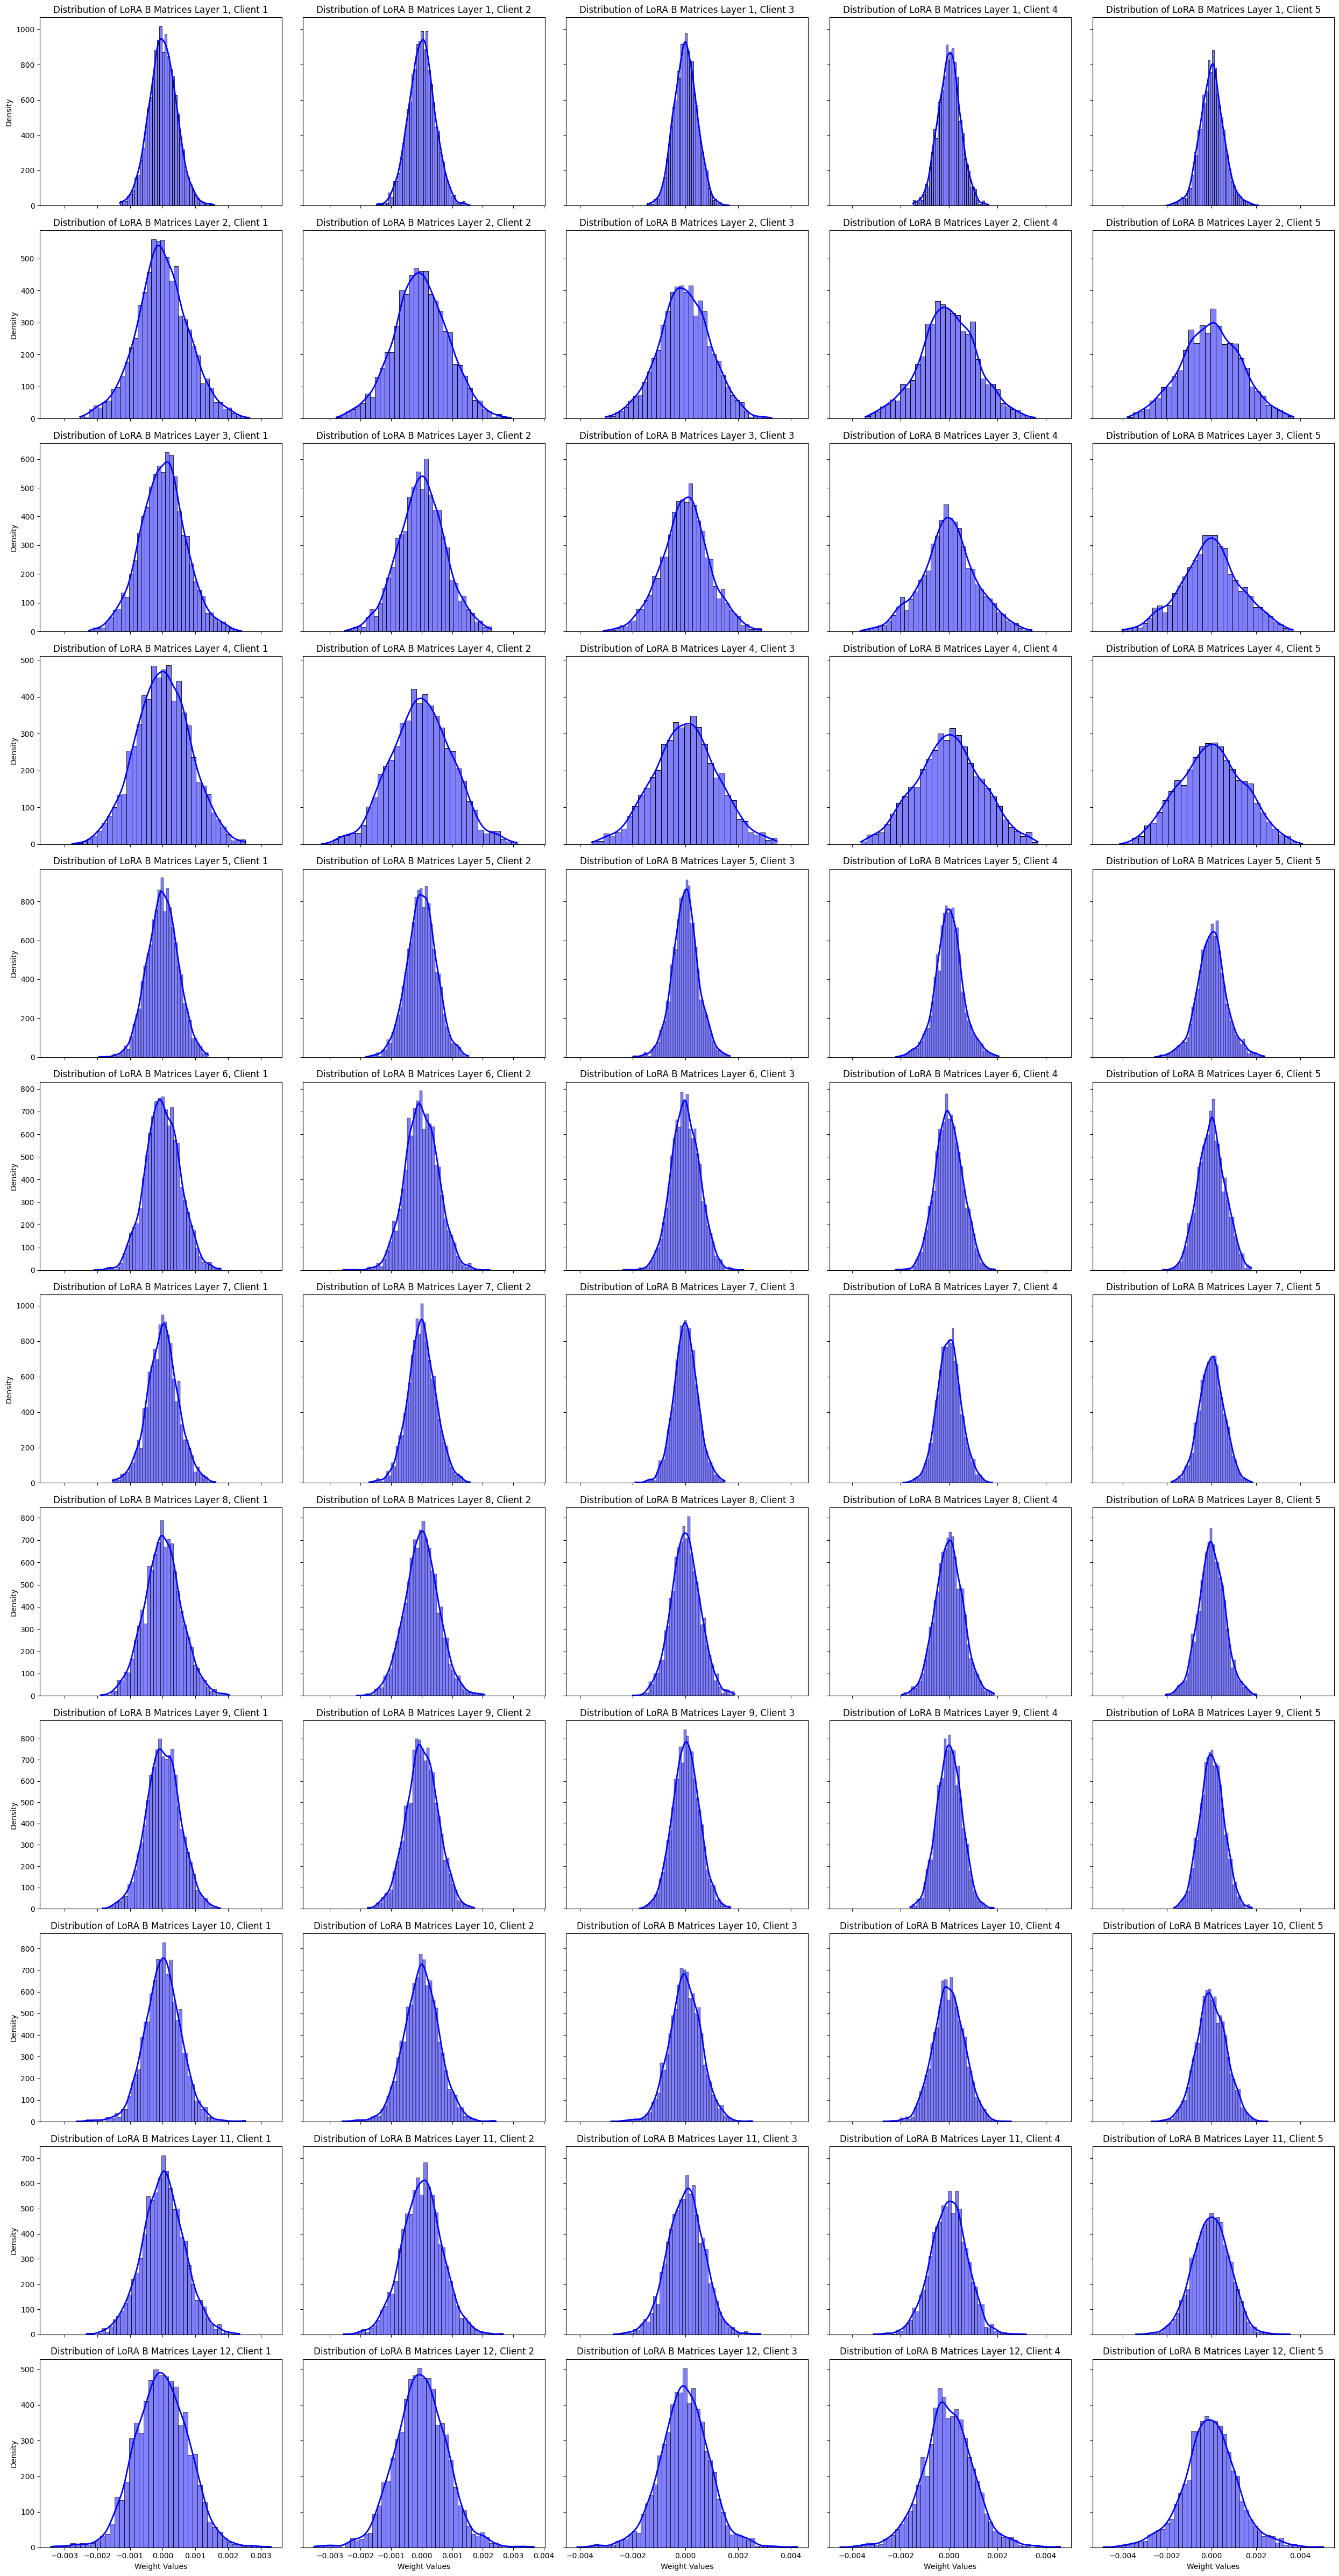

In [491]:
num_layers = 12  # For BERT-Base
weights = [result[pr] for pr in poison_ratios]
A_matrices, B_matrices = extract_lora_matrices(weights, num_layers)

# visualize 
plot_histograms_for_clients(B_matrices, 'Distribution of LoRA B Matrices')